In [29]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.approximation import PiecewiseAggregateApproximation
import warnings
warnings.filterwarnings('ignore')

In [30]:
import os
os.getcwd()


'C:\\Users\\piyus\\mlenv\\gaitenv\\gait-in-neurodegenerative-disease-database-1.0.0'

In [31]:
dataset_dir = "C:\\Users\\piyus\\mlenv\\gaitenv\\gait-in-neurodegenerative-disease-database-1.0.0"
try:
    os.chdir(dataset_dir)
    print(f"Changed working directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"Error: Directory '{dataset_dir}' not found. Please check the path.")
    raise
except Exception as e:
    print(f"Error changing directory: {e}")
    raise

Changed working directory to: C:\Users\piyus\mlenv\gaitenv\gait-in-neurodegenerative-disease-database-1.0.0


In [32]:
try:
    subject_info = pd.read_csv("subject-description.txt", sep="\t")
    print("Subject description loaded successfully.")
    print("\nFirst few rows:")
    print(subject_info.head())
    print("\nColumn names:", list(subject_info.columns))
    print("Data types:\n", subject_info.dtypes)
except FileNotFoundError:
    print("Error: 'subject-description.txt' not found. Check the file path.")
    raise
except pd.errors.ParserError:
    print("Error: Failed to parse 'subject-description.txt'. Check file format.")
    raise
except Exception as e:
    print(f"Error loading subject description: {e}")
    raise

Subject description loaded successfully.

First few rows:
  Unnamed: 0    GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0   control1  control      57.0            1.94         95      f   
1   control2  control      22.0            1.94         70      m   
2   control3  control      23.0            1.83         66      f   
3   control4  control      52.0            1.78         73      f   
4   control5  control      47.0            1.94         82      f   

  GaitSpeed(m/sec)  Duration/Severity  
0             1.33                0.0  
1             1.47                0.0  
2             1.44                0.0  
3             1.54                0.0  
4             1.54                0.0  

Column names: ['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)', 'gender', 'GaitSpeed(m/sec)', 'Duration/Severity']
Data types:
 Unnamed: 0            object
GROUP                 object
AGE(YRS)             float64
HEIGHT(meters)       float64
Weight(kg)            ob

In [33]:
print("\nColumn names:", list(subject_info.columns))


Column names: ['Unnamed: 0', 'GROUP', 'AGE(YRS)', 'HEIGHT(meters)', 'Weight(kg)', 'gender', 'GaitSpeed(m/sec)', 'Duration/Severity']


In [34]:
ts_files = glob.glob("*.ts")
print(f"Total .ts files found: {len(ts_files)}")
expected_files = 64
if len(ts_files) == 0:
    raise FileNotFoundError("No .ts files found in the directory.")
elif len(ts_files) != expected_files:
    print(f"Warning: Found {len(ts_files)} .ts files, expected {expected_files}.")
ts_files.sort()

Total .ts files found: 64


In [35]:
import re

data_dict = {}
for file in ts_files:
    subject_id = os.path.basename(file).replace(".ts", "")
    try:
        ts_data = pd.read_csv(file, sep=r"\s+", header=None)
        ts_data.columns = [
            "Time", "L_Stride", "R_Stride", "L_Swing", "R_Swing", 
            "L_Swing%", "R_Swing%", "L_Stance", "R_Stance", 
            "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
        ]
        if ts_data.isnull().any().any():
            ts_data = ts_data.interpolate()
            print(f"Interpolated missing values for {subject_id}")
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue
    subj_info_row = subject_info[subject_info["Unnamed: 0"] == subject_id]
    if not subj_info_row.empty:
        if "Group" in subject_info.columns:
            group = subj_info_row["Group"].iloc[0]
            print(f"Using Group from subject_info for {subject_id}: {group}")
        else:
            # Extract group as alphabetical prefix before digits
            match = re.match(r"([a-z]+)", subject_id)
            if match:
                group = match.group(1)
            else:
                group = "unknown"
            print(f"Extracted group for {subject_id}: {group}")
        data_dict[subject_id] = {
            "group": group,
            "time_series": ts_data,
            "info": subj_info_row.to_dict(orient="records")[0]
        }
    else:
        print(f"Warning: {subject_id} not found in subject-description.txt")

Extracted group for als1: als
Extracted group for als10: als
Extracted group for als11: als
Extracted group for als12: als
Extracted group for als13: als
Extracted group for als2: als
Extracted group for als3: als
Extracted group for als4: als
Extracted group for als5: als
Extracted group for als6: als
Extracted group for als7: als
Extracted group for als8: als
Extracted group for als9: als
Extracted group for control1: control
Extracted group for control10: control
Extracted group for control11: control
Extracted group for control12: control
Extracted group for control13: control
Extracted group for control14: control
Extracted group for control15: control
Extracted group for control16: control
Extracted group for control2: control
Extracted group for control3: control
Extracted group for control4: control
Extracted group for control5: control
Extracted group for control6: control
Extracted group for control7: control
Extracted group for control8: control
Extracted group for control9:

In [36]:
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    subject_id = "park1"  # Updated from park01
    try:
        sample = data_dict[subject_id]
        print(f"Group: {sample['group']}")
        print("\nSubject Info:")
        print(pd.DataFrame([sample['info']]))
        print("\nTime Series Head:")
        print(sample['time_series'].head())
    except KeyError:
        print(f"Error: Subject '{subject_id}' not found in data_dict.")

Group: park

Subject Info:
  Unnamed: 0 GROUP  AGE(YRS)  HEIGHT(meters) Weight(kg) gender  \
0      park1  park      77.0             2.0         86      m   

  GaitSpeed(m/sec)  Duration/Severity  
0             0.98                4.0  

Time Series Head:
      Time  L_Stride  R_Stride  L_Swing  R_Swing  L_Swing%  R_Swing%  \
0  21.7700    1.1333    1.0933   0.3700   0.3300     32.65     30.18   
1  22.8767    1.1067    1.1200   0.3800   0.3500     34.34     31.25   
2  24.0833    1.2067    1.1467   0.4467   0.3800     37.02     33.14   
3  25.1667    1.0833    1.1200   0.3567   0.3133     32.92     27.98   
4  26.3433    1.1767    1.1567   0.4333   0.3633     36.83     31.41   

   L_Stance  R_Stance  L_Stance%  R_Stance%  DoubleSupport  DoubleSupport%  
0    0.7633    0.7633      67.35      69.82         0.4333           38.24  
1    0.7267    0.7700      65.66      68.75         0.3767           34.04  
2    0.7600    0.7667      62.98      66.86         0.3800           31.49  


In [37]:
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    print("Checking for missing values in time series data...")
    for sid, record in data_dict.items():
        ts_data = record["time_series"]
        if ts_data["L_Stride"].isnull().any():
            print(f"Missing values in L_Stride for subject: {sid}")
        else:
            print(f"No missing values in L_Stride for subject: {sid}")

Checking for missing values in time series data...
No missing values in L_Stride for subject: als1
No missing values in L_Stride for subject: als10
No missing values in L_Stride for subject: als11
No missing values in L_Stride for subject: als12
No missing values in L_Stride for subject: als13
No missing values in L_Stride for subject: als2
No missing values in L_Stride for subject: als3
No missing values in L_Stride for subject: als4
No missing values in L_Stride for subject: als5
No missing values in L_Stride for subject: als6
No missing values in L_Stride for subject: als7
No missing values in L_Stride for subject: als8
No missing values in L_Stride for subject: als9
No missing values in L_Stride for subject: control1
No missing values in L_Stride for subject: control10
No missing values in L_Stride for subject: control11
No missing values in L_Stride for subject: control12
No missing values in L_Stride for subject: control13
No missing values in L_Stride for subject: control14
No m

In [38]:
if not data_dict:
    print("Error: data_dict is empty. Check previous steps.")
else:
    print("Validating data_dict entries...")
    required_keys = {"group", "info", "time_series"}
    for sid, record in data_dict.items():
        missing_keys = required_keys - set(record.keys())
        if missing_keys:
            print(f"Incomplete entry for {sid}: Missing keys {missing_keys}")
        else:
            print(f"Complete entry for {sid}")

Validating data_dict entries...
Complete entry for als1
Complete entry for als10
Complete entry for als11
Complete entry for als12
Complete entry for als13
Complete entry for als2
Complete entry for als3
Complete entry for als4
Complete entry for als5
Complete entry for als6
Complete entry for als7
Complete entry for als8
Complete entry for als9
Complete entry for control1
Complete entry for control10
Complete entry for control11
Complete entry for control12
Complete entry for control13
Complete entry for control14
Complete entry for control15
Complete entry for control16
Complete entry for control2
Complete entry for control3
Complete entry for control4
Complete entry for control5
Complete entry for control6
Complete entry for control7
Complete entry for control8
Complete entry for control9
Complete entry for hunt1
Complete entry for hunt10
Complete entry for hunt11
Complete entry for hunt12
Complete entry for hunt13
Complete entry for hunt14
Complete entry for hunt15
Complete entry f

In [39]:
if not data_dict:
    print("Error: data_dict is empty. No samples to list.")
else:
    print(f"Listing all {len(data_dict)} samples in data_dict:")
    print(f"{'Subject ID':<15} {'Group':<10} {'In subject_info':<15}")
    print("-" * 40)
    sorted_samples = sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0]))
    for sid, record in sorted_samples:
        in_subject_info = "Yes" if sid in subject_info["Unnamed: 0"].values else "No"
        print(f"{sid:<15} {record['group']:<10} {in_subject_info:<15}")
    print(f"\nTotal samples: {len(data_dict)} (expected 64)")

Listing all 64 samples in data_dict:
Subject ID      Group      In subject_info
----------------------------------------
als1            als        Yes            
als10           als        Yes            
als11           als        Yes            
als12           als        Yes            
als13           als        Yes            
als2            als        Yes            
als3            als        Yes            
als4            als        Yes            
als5            als        Yes            
als6            als        Yes            
als7            als        Yes            
als8            als        Yes            
als9            als        Yes            
control1        control    Yes            
control10       control    Yes            
control11       control    Yes            
control12       control    Yes            
control13       control    Yes            
control14       control    Yes            
control15       control    Yes            
control16       con

In [40]:
if not data_dict:
    print("Error: data_dict is empty. No samples to analyze.")
else:
    print(f"Analyzing duration and feature consistency for {len(data_dict)} samples:")
    print(f"{'Subject ID':<15} {'Group':<10} {'Duration (s)':<15} {'Features Consistent':<20}")
    print("-" * 60)
    
    feature_columns = [
        "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
        "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
    ]
    
    for sid, record in sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0])):
        ts_data = record["time_series"]
        try:
            duration = ts_data["Time"].max() - ts_data["Time"].min()
            time_count = ts_data["Time"].count()
            consistent = all(ts_data[col].count() == time_count for col in feature_columns)
            print(f"{sid:<15} {record['group']:<10} {duration:<15.2f} {str(consistent):<20}")
        except Exception as e:
            print(f"Error processing {sid}: {e}")
    
    print(f"\nTotal samples analyzed: {len(data_dict)} (expected 64)")

Analyzing duration and feature consistency for 64 samples:
Subject ID      Group      Duration (s)    Features Consistent 
------------------------------------------------------------
als1            als        250.64          True                
als10           als        277.78          True                
als11           als        277.11          True                
als12           als        277.04          True                
als13           als        276.72          True                
als2            als        276.91          True                
als3            als        276.95          True                
als4            als        275.67          True                
als5            als        266.96          True                
als6            als        275.69          True                
als7            als        275.92          True                
als8            als        276.13          True                
als9            als        276.45          True 

In [41]:
import scipy.ndimage

output_dir = "gaf_images"
if not data_dict:
    print("Error: data_dict is empty. Cannot generate GAF images.")
else:
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    
    feature_columns = [
        "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
        "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
    ]
    
    print(f"Generating RGB GAF images (224x224) for {len(data_dict)} subjects, {len(feature_columns)} features each...")
    total_images = 0
    skipped = []
    
    for sid, record in sorted(data_dict.items(), key=lambda x: (x[1]["group"], x[0])):
        group = record["group"]
        ts_data = record["time_series"]
        
        for column_name in feature_columns:
            try:
                signal = ts_data[column_name].values
                
                # Skip if signal is empty or invalid
                if signal.size == 0 or not np.isfinite(signal).all():
                    skipped.append((sid, column_name, "Invalid data"))
                    continue
                
                # Pad short signals to at least 224 points
                if signal.size < 224:
                    pad_length = 224 - signal.size
                    signal = np.pad(signal, (0, pad_length), mode='edge')
                    print(f"Padded {sid}, {column_name} from {signal.size-pad_length} to 224 points")
                
                # Apply PAA to get exactly 224 points
                paa = PiecewiseAggregateApproximation(window_size=None, output_size=224)
                signal_resampled = paa.fit_transform([signal])[0]
                
                # Verify resampled length
                if len(signal_resampled) != 224:
                    skipped.append((sid, column_name, f"Resampled to {len(signal_resampled)} points, expected 224"))
                    continue
                
                # Normalize to [-1, 1]
                if np.max(signal_resampled) != np.min(signal_resampled):
                    signal_normalized = 2 * ((signal_resampled - np.min(signal_resampled)) / (np.max(signal_resampled) - np.min(signal_resampled))) - 1
                else:
                    signal_normalized = np.zeros_like(signal_resampled)
                    print(f"Warning: {column_name} for {sid} is constant, normalized to zeros")
                
                # Apply GASF
                gaf_sum = GramianAngularField(method='summation')
                gasf_image = gaf_sum.fit_transform([signal_normalized])[0]
                
                # Apply GADF
                gaf_diff = GramianAngularField(method='difference')
                gadf_image = gaf_diff.fit_transform([signal_normalized])[0]
                
                # Compute blue channel: absolute difference
                blue_channel = np.abs(signal_normalized[:, None] - signal_normalized[None, :]) / 2
                
                # Resize images if not 224x224
                for img, name in [(gasf_image, "GASF"), (gadf_image, "GADF"), (blue_channel, "Blue")]:
                    if img.shape != (224, 224):
                        zoom_factors = (224 / img.shape[0], 224 / img.shape[1])
                        img = scipy.ndimage.zoom(img, zoom_factors, order=1)
                        print(f"Resized {name} for {sid}, {column_name} from {img.shape} to (224, 224)")
                
                # Normalize GASF and GADF to [0, 1]
                gasf_norm = (gasf_image - gasf_image.min()) / (gasf_image.max() - gasf_image.min())
                gadf_norm = (gadf_image - gadf_image.min()) / (gadf_image.max() - gadf_image.min())
                
                # Create RGB image
                rgb_image = np.zeros((224, 224, 3))
                rgb_image[:, :, 0] = gasf_norm
                rgb_image[:, :, 1] = gadf_norm
                rgb_image[:, :, 2] = blue_channel
                
                # Save image
                feature_dir = os.path.join(output_dir, group, column_name)
                if not os.path.exists(feature_dir):
                    os.makedirs(feature_dir)
                
                plt.figure(figsize=(6, 6))
                plt.imshow(rgb_image, origin='lower')
                plt.axis('off')
                output_path = os.path.join(feature_dir, f"{sid}.png")
                plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
                plt.close()
                
                total_images += 1
                print(f"Saved RGB GAF image: {output_path}")
            except Exception as e:
                skipped.append((sid, column_name, str(e)))
                print(f"Error processing {sid}, {column_name}: {e}")
    
    print(f"\nTotal RGB GAF images generated: {total_images} (expected {len(data_dict) * len(feature_columns)})")
    if skipped:
        print("\nSkipped subjects/features:")
        for sid, feat, reason in skipped:
            print(f"{sid}, {feat}: {reason}")

Created output directory: gaf_images
Generating RGB GAF images (224x224) for 64 subjects, 12 features each...
Padded als1, L_Stride from 194 to 224 points
Saved RGB GAF image: gaf_images\als\L_Stride\als1.png
Padded als1, R_Stride from 194 to 224 points
Saved RGB GAF image: gaf_images\als\R_Stride\als1.png
Padded als1, L_Swing from 194 to 224 points
Saved RGB GAF image: gaf_images\als\L_Swing\als1.png
Padded als1, R_Swing from 194 to 224 points
Saved RGB GAF image: gaf_images\als\R_Swing\als1.png
Padded als1, L_Swing% from 194 to 224 points
Saved RGB GAF image: gaf_images\als\L_Swing%\als1.png
Padded als1, R_Swing% from 194 to 224 points
Saved RGB GAF image: gaf_images\als\R_Swing%\als1.png
Padded als1, L_Stance from 194 to 224 points
Saved RGB GAF image: gaf_images\als\L_Stance\als1.png
Padded als1, R_Stance from 194 to 224 points
Saved RGB GAF image: gaf_images\als\R_Stance\als1.png
Padded als1, L_Stance% from 194 to 224 points
Saved RGB GAF image: gaf_images\als\L_Stance%\als1.png
P

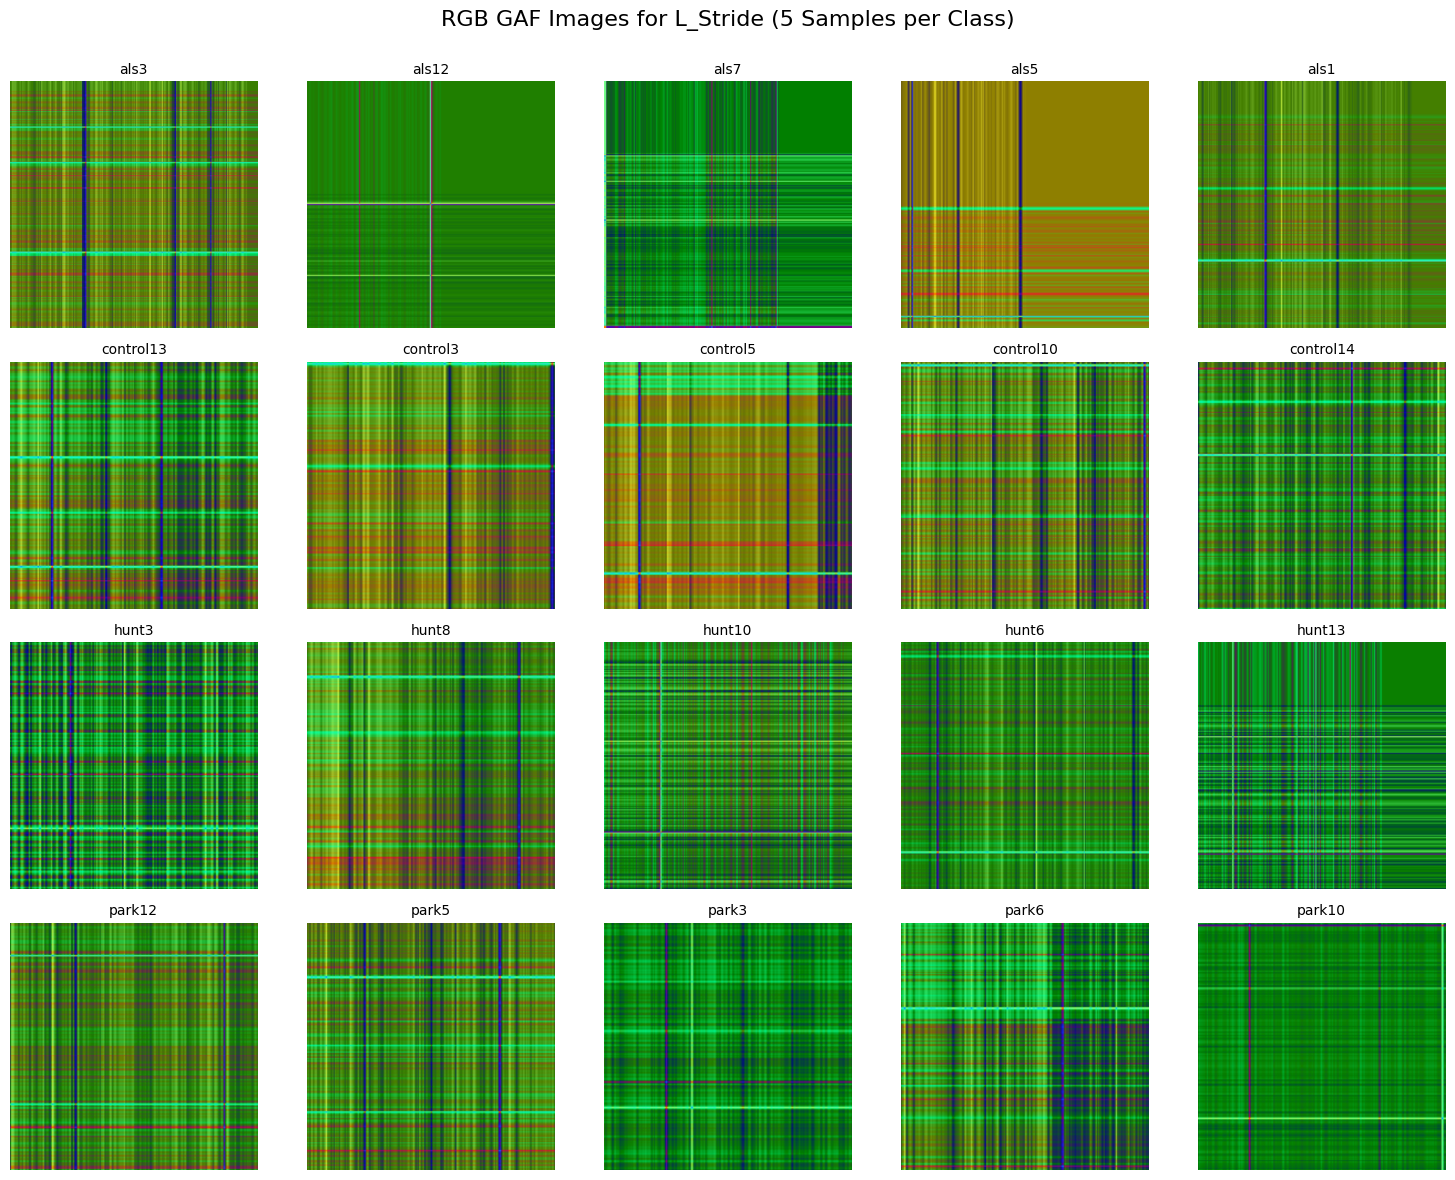

In [52]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define paths and classes
gaf_images_dir = "gaf_images"
classes = ["als", "control", "hunt", "park"]
feature = "R_Swing%"
num_samples = 5

# Dictionary to store subject IDs for each class
subject_ids = {
    "als": [f"als{i}" for i in range(1, 14)],  # als1 to als13
    "control": [f"control{i}" for i in range(1, 17)],  # cont1 to cont16
    "hunt": [f"hunt{i}" for i in range(1, 17)],  # hunt1 to hunt16
    "park": [f"park{i}" for i in range(1, 27)]  # park1 to park26
}

# Select 5 random subjects per class
selected_subjects = {}
for cls in classes:
    available_ids = subject_ids[cls]
    # Check which subjects have L_Stride images
    valid_ids = [
        sid for sid in available_ids
        if os.path.exists(os.path.join(gaf_images_dir, cls, feature, f"{sid}.png"))
    ]
    if len(valid_ids) < num_samples:
        print(f"Warning: Only {len(valid_ids)} subjects available for {cls}, need {num_samples}")
        selected_subjects[cls] = random.sample(valid_ids, len(valid_ids))
    else:
        selected_subjects[cls] = random.sample(valid_ids, num_samples)

# Create a 4x5 subplot grid
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle("RGB GAF Images for L_Stride (5 Samples per Class)", fontsize=16)

# Plot images
for row, cls in enumerate(classes):
    for col, sid in enumerate(selected_subjects[cls]):
        # Load image
        img_path = os.path.join(gaf_images_dir, cls, feature, f"{sid}.png")
        try:
            img = Image.open(img_path)
            # Display image
            axes[row, col].imshow(img)
            axes[row, col].set_title(sid, fontsize=10)
            axes[row, col].axis("off")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axes[row, col].text(0.5, 0.5, "Image Not Found", ha="center", va="center")
            axes[row, col].axis("off")
    
    # Add class label to the left of the row
    axes[row, 0].set_ylabel(cls.upper(), fontsize=12, rotation=0, labelpad=40)

# Adjust layout to prevent overlap
plt.tight_layout()
fig.subplots_adjust(top=0.92)

# Display the plot
plt.show()